In [1]:
import logging
import os
import re
import grpc

import epl.protobuf.stac_pb2 as stac
import epl.grpc.naip_stac_pb2_grpc as naip_grpc
import epl.protobuf.geometry_operators_pb2 as geometry


logger = logging.getLogger(__name__)

MB = 1024 * 1024
GRPC_CHANNEL_OPTIONS = [('grpc.max_message_length', 64 * MB), ('grpc.max_receive_message_length', 64 * MB)]
GRPC_SERVICE_PORT = os.getenv('GRPC_SERVICE_PORT', 50051)
GRPC_SERVICE_HOST = os.getenv('GRPC_SERVICE_HOST', 'localhost')
IMAGERY_SERVICE = "{0}:{1}".format(GRPC_SERVICE_HOST, GRPC_SERVICE_PORT)
ip_reg = re.compile(r"[\d]{1,3}\.[\d]{1,3}\.[\d]{1,3}\.[\d]{1,3}")

if GRPC_SERVICE_HOST == "localhost" or ip_reg.match(GRPC_SERVICE_HOST):
    channel = grpc.insecure_channel(IMAGERY_SERVICE, options=GRPC_CHANNEL_OPTIONS)
else:
    channel_credentials = grpc.ssl_channel_credentials()
    channel = grpc.secure_channel(IMAGERY_SERVICE, credentials=channel_credentials, options=GRPC_CHANNEL_OPTIONS)

stub = naip_grpc.MetadataOperatorsStub(channel)

In [2]:
eo_geometry = stac.GeometryField(geometry=geometry.GeometryData(wkt="POINT(-121.4944 38.5816)"))
metadata_request = stac.MetadataRequest(geometry=eo_geometry,
                                        eo_gsd=stac.FloatField(value=1.0, rel_type=stac.FIELD_LESS_EQUAL))

results_generator = stub.Search(metadata_request)
for metadata_result in results_generator:
    assets = metadata_result.assets
    for asset_key in assets:
        asset = assets[asset_key]
        for field in asset.DESCRIPTOR.fields:
            if asset.HasField(field.name):
                print("field {0} has value {1}".format(field.name, getattr(asset, field.name)))
            else:
                print("field {0} skipped because not set".format(field.name))

field href skipped because not set
field asset_type has value 4
field eo_band has value 60
field bucket_iaas_host has value 1
field bucket_owner skipped because not set
field bucket_region skipped because not set
field bucket_ref has value s3://naip-analytic/ca/2014/100cm/rgbir/38121/m_3812129_nw_10_1_20140621.mrf
field href skipped because not set
field asset_type has value 5
field eo_band has value 60
field bucket_iaas_host has value 1
field bucket_owner skipped because not set
field bucket_region skipped because not set
field bucket_ref has value s3://naip-analytic/ca/2014/100cm/rgbir/38121/m_3812129_nw_10_1_20140621.idx
field href skipped because not set
field asset_type has value 3
field eo_band has value 60
field bucket_iaas_host has value 1
field bucket_owner skipped because not set
field bucket_region skipped because not set
field bucket_ref has value s3://naip-analytic/ca/2014/100cm/rgbir/38121/m_3812129_nw_10_1_20140621.lrc
field href skipped because not set
field asset_type 

In [3]:
import rasterio

In [4]:
Session = rasterio.Env(
    AWS_REQUEST_PAYER='requester',
    GDAL_DISABLE_READDIR_ON_OPEN='YES',
    AWS_PROFILE='${HOME}/.aws/credentials')

In [5]:
results_generator = stub.Search(metadata_request)
for metadata_result in results_generator:
    print("")
    print("")
    for field in metadata_result.DESCRIPTOR.fields:
        if field.name == 'assets':
            continue
        if metadata_result.HasField(field.name):
            print("field {0} has value {1}".format(field.name, getattr(metadata_result, field.name)))
        else:
            print("field {0} skipped because not set".format(field.name))



field id has value m_3812129_nw_10_1_20140621_20141007.tif
field eo_platform skipped because not set
field eo_instrument skipped because not set
field eo_cloud_cover skipped because not set
field eo_sun_azimuth skipped because not set
field eo_sun_elevation skipped because not set
field eo_gsd has value 1.0
field eo_off_nadir skipped because not set
field bbox skipped because not set
field geometry has value wkb: "\001\003\000\000 \346\020\000\000\001\000\000\000\005\000\000\000\000\000\000\000\000`^\300\r\006\376\377\377OC@\377\377\377\377\377[^\300\r\006\376\377\377OC@\377\377\377\377\377[^\300M\006\376\377\377GC@\000\000\000\000\000`^\300M\006\376\377\377GC@\000\000\000\000\000`^\300\r\006\376\377\377OC@"

field src_img_date has value seconds: 1403308800

field usgsid has value 3812129


field id has value m_3812129_nw_10_h_20160621_20161004.tif
field eo_platform skipped because not set
field eo_instrument skipped because not set
field eo_cloud_cover skipped because not set
field 

In [6]:
results_generator = stub.Search(metadata_request)
for metadata_result in results_generator:
    assets = metadata_result.assets
    for asset_key in assets:
        asset = assets[asset_key]
        if asset.asset_type == stac.GEOTIFF:
            print(asset.bucket_ref)
            with Session:
                with rasterio.open(asset.bucket_ref) as src:

                    print(src.profile)

s3://naip-visualization/ca/2014/100cm/rgb/38121/m_3812129_nw_10_1_20140621.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6161, 'height': 7628, 'count': 3, 'crs': CRS({'init': 'epsg:26910'}), 'transform': Affine(1.0, 0.0, 630273.0,
       0.0, -1.0, 4276622.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'jpeg', 'interleave': 'pixel', 'photometric': 'ycbcr'}
s3://naip-source/ca/2014/100cm/rgbir/38121/m_3812129_nw_10_1_20140621.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6161, 'height': 7628, 'count': 4, 'crs': CRS({'init': 'epsg:26910'}), 'transform': Affine(1.0, 0.0, 630273.0,
       0.0, -1.0, 4276622.0), 'tiled': False, 'interleave': 'pixel'}
s3://naip-source/ca/2016/60cm/rgbir/38121/m_3812129_nw_10_h_20160621.tif
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9780, 'height': 12220, 'count': 4, 'crs': CRS({'init': 'epsg:26910'}), 'transform': Affine(0.6, 0.0, 630420.0,
       0.0, -0.6, 4276476.0), 'tile

s3://naip-visualization/ca/2016/60cm/rgb/38121/m_3812129_nw_10_h_20160621.tif


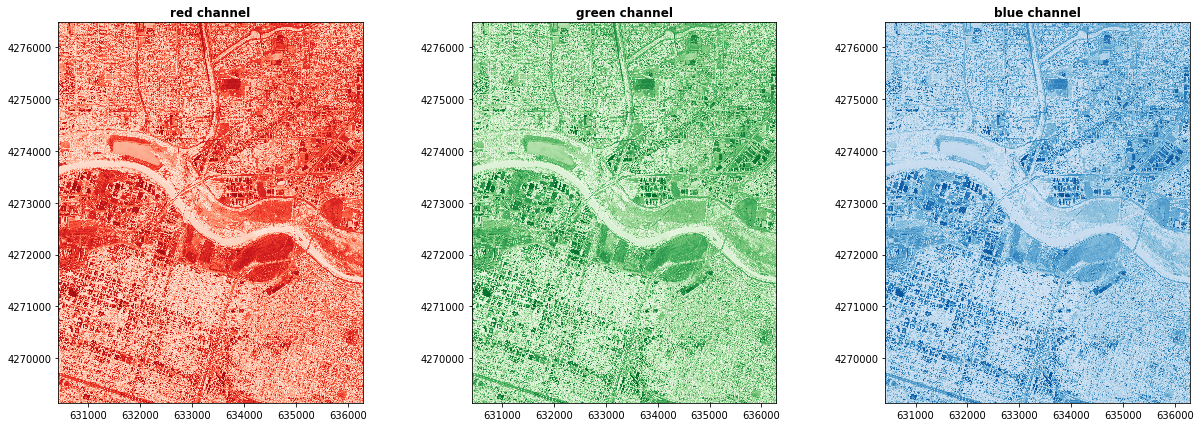

In [8]:
from rasterio.plot import show
from matplotlib import pyplot
metadata_request = stac.MetadataRequest(geometry=eo_geometry,
                                        eo_gsd=stac.FloatField(value=0.6, rel_type=stac.FIELD_LESS_EQUAL))
results_generator = stub.Search(metadata_request)
for metadata_result in results_generator:
    assets = metadata_result.assets
    for asset_key in assets:
        asset = assets[asset_key]
        if asset.asset_type == stac.GEOTIFF and asset.eo_band == stac.RGB_BANDS:
            print(asset.bucket_ref)
            with Session:
                with rasterio.open(asset.bucket_ref) as src:
                    fig, (axr, axg, axb) = pyplot.subplots(1,3, figsize=(21,7))
                    show((src, 1), ax=axr, cmap='Reds', title='red channel')
                    show((src, 2), ax=axg, cmap='Greens', title='green channel')
                    show((src, 3), ax=axb, cmap='Blues', title='blue channel')
                    pyplot.show()